In [ ]:
#!pip install osmnx==0.14.1
!pip install osmnx==0.16.2

In [ ]:
import networkx as nx
import pandas as pd
import osmnx as ox
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'0.16.2'

# **Toda SP**

In [ ]:
G = ox.graph_from_place('São Paulo, Brasil', network_type='drive')
fig, ax = ox.plot_graph(G)

# **Restaurante Rico Sabor**

In [ ]:
# network from address, including only nodes within 5km along the network from the address
G = ox.graph_from_address(address='Avenida Adolfo Pinheiro 1806, Santo Amaro, São Paulo, Brasil', dist=4000,
                          dist_type='network')

#project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)

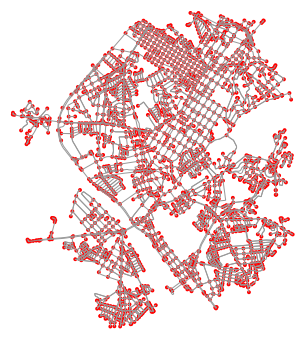

In [ ]:
fig, ax = ox.plot_graph(G, node_color='r')

In [ ]:
len(G)

4339

In [ ]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
nodes, streets = ox.graph_to_gdfs(G)

In [ ]:
nodes

,y,x,osmid,highway,geometry
25675079,-23.625770,-46.709095,25675079,NaN,POINT (-46.70909 -23.62577)
25675120,-23.626521,-46.710316,25675120,NaN,POINT (-46.71032 -23.62652)
25675209,-23.631759,-46.715301,25675209,NaN,POINT (-46.71530 -23.63176)
25675372,-23.639380,-46.722796,25675372,NaN,POINT (-46.72280 -23.63938)
25675374,-23.638271,-46.721431,25675374,NaN,POINT (-46.72143 -23.63827)
...,...,...,...,...,...
8231239516,-23.631522,-46.697938,8231239516,NaN,POINT (-46.69794 -23.63152)
8303585452,-23.650318,-46.700643,8303585452,NaN,POINT (-46.70064 -23.65032)
8303585453,-23.650578,-46.700818,8303585453,NaN,POINT (-46.70082 -23.65058)
8303600650,-23.639964,-46.696561,8303600650,NaN,POINT (-46.69656 -23.63996)


In [ ]:
streets

,osmid,oneway,name,highway,length,geometry,speed_kph,travel_time,lanes,maxspeed,ref,bridge,service,access,junction,tunnel,u,v,key
0,23023471,True,Rua Rubens Sverner,residential,138.232,"LINESTRING (-46.70909 -23.62577, -46.70917 -23...",32.7,15.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25675079,248231193,0
1,248521878,True,Avenida das Nações Unidas,trunk,56.028,"LINESTRING (-46.70909 -23.62577, -46.70899 -23...",60.0,3.4,3,60,NaN,NaN,NaN,NaN,NaN,NaN,25675079,248231256,0
2,260187506,False,Rua Américo Brasiliense,residential,63.628,"LINESTRING (-46.71032 -23.62652, -46.70979 -23...",32.7,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25675120,248231193,0
3,248521878,True,Avenida das Nações Unidas,trunk,150.132,"LINESTRING (-46.71032 -23.62652, -46.70993 -23...",60.0,9.0,3,60,NaN,NaN,NaN,NaN,NaN,NaN,25675120,25675079,0
4,463947012,True,Avenida das Nações Unidas,trunk,67.127,"LINESTRING (-46.71530 -23.63176, -46.71488 -23...",60.0,4.0,3,60,NaN,NaN,NaN,NaN,NaN,NaN,25675209,4411605847,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9899,893412806,False,NaN,service,34.042,"LINESTRING (-46.70082 -23.65058, -46.70072 -23...",15.8,7.8,NaN,NaN,NaN,NaN,parking_aisle,customers,NaN,NaN,8303585453,8303585452,0
9900,499154209,True,Avenida Vereador José Diniz,primary,57.270,"LINESTRING (-46.69656 -23.63996, -46.69671 -23...",50.0,4.1,3,50,NaN,NaN,NaN,NaN,NaN,NaN,8303600650,2514281694,0
9901,893413208,False,NaN,service,48.260,"LINESTRING (-46.69656 -23.63996, -46.69663 -23...",15.8,11.0,NaN,NaN,NaN,NaN,parking_aisle,customers,NaN,NaN,8303600650,8303600651,0
9902,244035439,True,Avenida Adolfo Pinheiro,primary,125.414,"LINESTRING (-46.69695 -23.63971, -46.69683 -23...",50.0,9.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8303600651,301868171,0


In [ ]:
useful_data = pd.DataFrame(streets[['name','highway','geometry']].replace("residential","Residencial"))
useful_data.loc[useful_data['highway'] != "Residencial","highway"] = "Outro"

In [ ]:
useful_data['name'].replace('', np.nan)
useful_data = useful_data.dropna(subset=['name'])

In [ ]:
useful_data = useful_data.applymap(lambda x: x[0] if isinstance(x, list) else x)
useful_data = useful_data.drop_duplicates(subset="name")
useful_data

,name,highway,geometry
0,Rua Rubens Sverner,Residencial,"LINESTRING (-46.7090946 -23.6257703, -46.70916..."
1,Avenida das Nações Unidas,Outro,"LINESTRING (-46.7090946 -23.6257703, -46.70899..."
2,Rua Américo Brasiliense,Residencial,"LINESTRING (-46.7103159 -23.6265209, -46.70979..."
5,Via Professor Simão Faiguenboim;Avenida Margin...,Outro,"LINESTRING (-46.7227963 -23.6393803, -46.72192..."
7,Avenida Maria Coelho de Aguiar,Outro,"LINESTRING (-46.7272334 -23.6417354, -46.72735..."
...,...,...,...
8405,Corredor de Ônibus Avenida Atlântica,Outro,"LINESTRING (-46.7125962 -23.6791403, -46.71252..."
9120,Rua Jaime de Oliveira Souza,Outro,"LINESTRING (-46.6923469 -23.6804021, -46.69239..."
9142,Praça Elfos,Residencial,"LINESTRING (-46.6855628 -23.6562581, -46.68541..."
9172,Praça Ponte de Coronados,Outro,"LINESTRING (-46.7119148 -23.6693346, -46.71187..."


In [ ]:
# impute missing edge speeds then calculate edge travel times

indice_orig = useful_data.loc[useful_data['name']=='Avenida Adolfo Pinheiro'].index.values[0]

orig = ox.get_nearest_node(G, (np.mean(useful_data['geometry'][indice_orig].coords.xy[1]), np.mean(useful_data['geometry'][indice_orig].coords.xy[0])))
distances = []

## Calculating Distance to each point to the origin (Restaurante Rico Sabor)

for i in useful_data.index:

  dest_lat = np.mean(useful_data['geometry'][i].coords.xy[1])
  dest_long = np.mean(useful_data['geometry'][i].coords.xy[0])
  dest = ox.get_nearest_node(G,(dest_lat,dest_long))

  route = ox.shortest_path(G, orig, dest, weight='travel_time')
  edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
  distances.append(round(sum(edge_lengths),2))

In [ ]:
useful_data["distances"] = distances
useful_data["travel_time(h)"] = useful_data["distances"]/30000

In [ ]:
useful_data = useful_data[['name','highway','distances','travel_time(h)']]

In [ ]:
useful_data 

,name,highway,distances,travel_time(h)
0,Rua Rubens Sverner,Residencial,3042.97,0.101432
1,Avenida das Nações Unidas,Outro,3216.32,0.107211
2,Rua Américo Brasiliense,Residencial,3000.54,0.100018
5,Via Professor Simão Faiguenboim;Avenida Margin...,Outro,3913.62,0.130454
7,Avenida Maria Coelho de Aguiar,Outro,4018.46,0.133949
...,...,...,...,...
8405,Corredor de Ônibus Avenida Atlântica,Outro,4558.13,0.151938
9120,Rua Jaime de Oliveira Souza,Outro,5171.86,0.172395
9142,Praça Elfos,Residencial,3104.37,0.103479
9172,Praça Ponte de Coronados,Outro,4074.90,0.135830


In [ ]:
useful_data.to_csv("Rico_Sabor_5KM.csv",sep="=") 

# **Restaurante Rico Sabor 2**

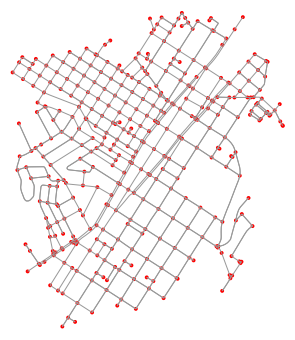

In [ ]:
restaurante_rico_sabor = (-23.638447112371054, -46.696090159603266)
G = ox.graph_from_point(restaurante_rico_sabor, dist=1500, dist_type='network', network_type='drive')
fig, ax = ox.plot_graph(G, node_color='r')